# <center> Финальное задание </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
#### Ваше задание - предсказать пол клиента, основываясь на его транзакционных исторических данных. Выполнение финального задания - это маленький шаг в большую Data Science-всесенную, поэтому отнеситесь к нему максимально серьёзно :)
#### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:02m


In [2]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

/tmp/ipykernel_426175/1555668456.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [5]:
PATH_DATA = './data'
MODEL_PATH = "model.pkl"

In [21]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [22]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    
    joblib.dump(clf, MODEL_PATH)
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

Так как код для оценки модели на тренировочных данных и её применения на тестовых данных уже дан, то мы будем работать над тем, чтобы создать переменные для улучшения результатов моделирования. 

<font color='red'><b>!!!</b></font> В рамках данного задания Вы можете делать всё, что угодно - использовать другие алгоритмы и/или их комбинации, подбирать гиперпараметры своих моделей, отбирать переменые, etc. Мы создали шаблон для простоты и для Вашего понимания верхнеуровневого процесса разработки модели, опустив при этом большое число деталей.

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [23]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

Добавлен параметр агрегации "sum". Метрика улучшена с 0.62 до 0.63

In [27]:
tqdm_notebook.pandas(desc="Progress")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [28]:
data_train.head()

amount,positive_transactions_min,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_std,positive_transactions_count,positive_transactions_sum,negative_transactions_min,negative_transactions_max,negative_transactions_mean,negative_transactions_median,negative_transactions_std,negative_transactions_count,negative_transactions_sum
client_id,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,722.09,42665.12,18450.900313,16450.65,14360.498086,32.0,590428.81,-39772.06,-6.13,-1881.786653,-269.295,4111.309461,472.0,-888203.30
0002f4661e0d4d2ae097d78552dad022,312.99,15909.56,2364.986667,723.37,5083.124389,9.0,21284.88,-9400.52,-6.58,-289.255194,-123.305,693.683636,258.0,-74627.84
00081e0eca8ad94e493691f8f00099c6,360.75,5423.80,1981.352400,1373.80,1704.496840,25.0,49533.81,-5424.42,-1.89,-379.101205,-144.935,701.946022,166.0,-62930.80
0019bebcb5435df3103a5b0b52f5fc6b,14.93,20247.50,1032.745050,722.43,1743.349204,301.0,310856.26,-36518.54,-0.32,-743.432256,-361.160,2027.349534,665.0,-494382.45
001c8191ecac499718b33dc293a99e5b,145.62,3616.52,1250.236923,723.71,950.703133,39.0,48759.24,-15907.79,-11.56,-1394.087964,-178.110,2918.020385,167.0,-232812.69


In [30]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:54:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.631+-0.012, Trees: 31


In [31]:
# Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:54:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


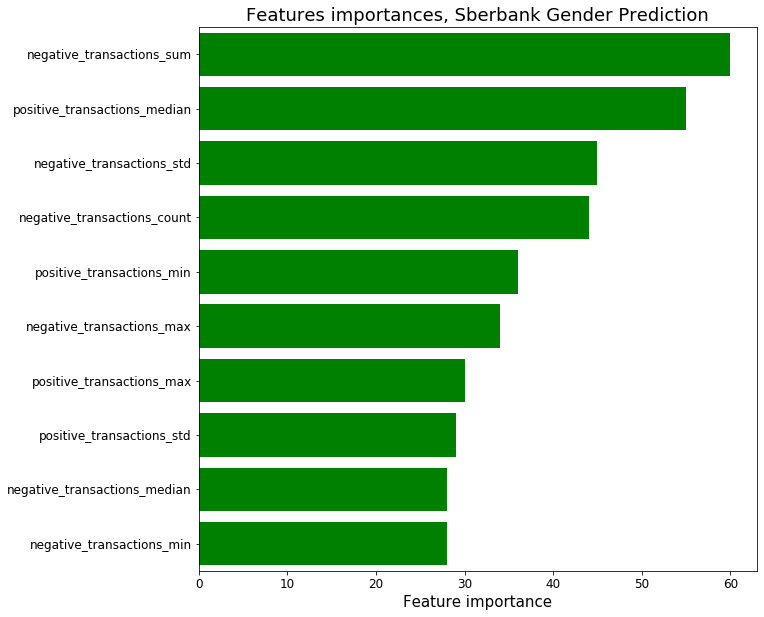

In [32]:
draw_feature_importances(clf, 10)

In [33]:
# Сохраняем результат моделирования

submission.to_csv('basic_features_submission.csv')

<font size=3>Видим, что результат на кросс-валидации = <font color='red'><b>62.2%</b></font> ROC AUC.

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [34]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [64]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
    
 
    return pd.concat(features)

In [65]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [66]:
data_train.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_sum,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std,positive_transactions_sum
client_id,,,,,,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,0.208333,0.123016,0.053571,0.117063,0.125000,0.156746,0.216270,NaN,NaN,0.085317,...,-888203.30,0.013889,0.986111,32.0,42665.12,18450.900313,16450.65,722.09,14360.498086,590428.81
0002f4661e0d4d2ae097d78552dad022,0.146067,0.161049,0.104869,0.179775,0.153558,0.149813,0.104869,0.007491,NaN,0.071161,...,-74627.84,0.056180,0.943820,9.0,15909.56,2364.986667,723.37,312.99,5083.124389,21284.88
00081e0eca8ad94e493691f8f00099c6,0.178010,0.188482,0.057592,0.146597,0.162304,0.157068,0.109948,0.036649,NaN,0.057592,...,-62930.80,0.157068,0.842932,25.0,5423.80,1981.352400,1373.80,360.75,1704.496840,49533.81
0019bebcb5435df3103a5b0b52f5fc6b,0.146998,0.165631,0.121118,0.142857,0.136646,0.140787,0.145963,0.203934,0.007246,0.021739,...,-494382.45,0.435818,0.564182,301.0,20247.50,1032.745050,722.43,14.93,1743.349204,310856.26
001c8191ecac499718b33dc293a99e5b,0.160194,0.111650,0.082524,0.203883,0.169903,0.169903,0.101942,0.092233,NaN,0.024272,...,-232812.69,0.271845,0.728155,39.0,3616.52,1250.236923,723.71,145.62,950.703133,48759.24


In [53]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:58:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.683+-0.012, Trees: 73


In [62]:
# Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:10:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


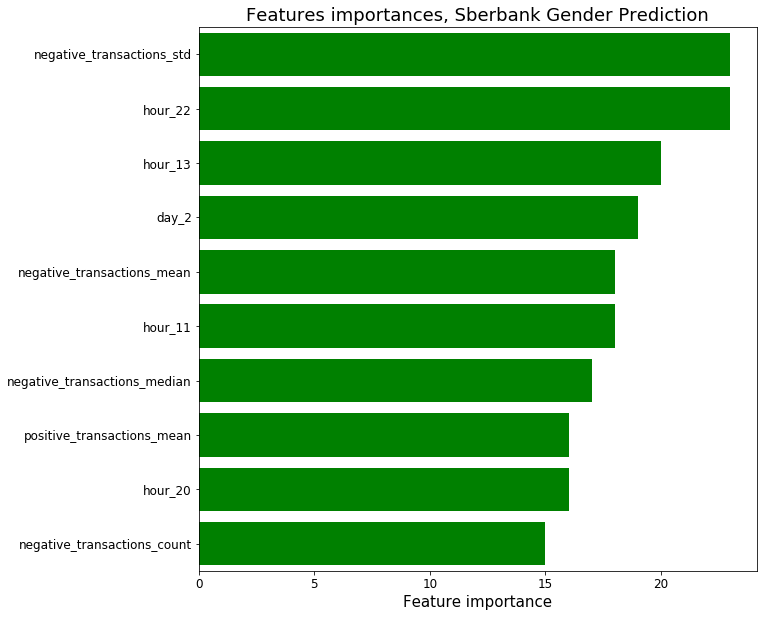

In [60]:
draw_feature_importances(clf, 10)

<font size=3>Добавление новых переменных улучшило наши результаты ROC AUC с <b>62.2%</b> до <font color='red'><b>68.4%</b></font>, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

In [61]:
# Сохраняем результат моделирования

submission.to_csv('advanced_features_submission.csv')

### <font color='red'>Цель задания:
Полученная модель должна иметь ROC AUC на Public-части тестовой выборки (на лидерборде) <b>не менее 80%.